# **Face Detection for digital cameras**

## Import

In [ ]:
# for download datasets and handle folders in colab env
!pip install -q kaggle
import json
import shutil

# for load images from drive
from google.colab import files

# for pick random files to handle datasets
import random
from random import sample

# for data augmentation
from keras.preprocessing.image import ImageDataGenerator

# for hog features extraction and resize operations
from skimage.feature import hog
from skimage.transform import resize

# for adapt to what Image.open expects
import io

# for open images and anti-aliasing operations
!pip install Pillow
from PIL import Image

# for model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# for work with array
import numpy as np

# for convert in gray scale
!pip install opencv-python
import cv2
import glob

# for plot bounding boxes
import matplotlib.pyplot as plt

In [1]:
# Say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Dataset preparation

### Faces dataset
I'll use Labelled Faces in the Wild (LFW) Dataset from Kaggle.

I chose this dataset because, according to the researchers at the University of Massachusetts (that have created and maintained the dataset), deep-funneled images produced superior results for most face verification algorithms compared to the other image types.

Each image is a 250x250 jpg.

In [3]:
_ = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
with open('kaggle.json') as f:
  kaggle_cred = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_cred['username']
os.environ['KAGGLE_KEY'] = kaggle_cred['key']

In [ ]:
!kaggle datasets download -d jessicali9530/lfw-dataset

!unzip /content/lfw-dataset.zip

In [6]:
directory = '/content/'

# Remove unnecessary files
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        os.remove(file_path)

In [7]:
# Source and destination directory path
source_directory = '/content/lfw-deepfunneled/lfw-deepfunneled'
destination_directory = '/content/volti'

# If not exist, create destination directory
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# For over all subdirectories
for root, dirs, files in os.walk(source_directory):
    for file in files:

        source_file_path = os.path.join(root, file)

        destination_file_path = os.path.join(destination_directory, file)

        shutil.move(source_file_path, destination_file_path)


print("All files are jpg." if all(file.lower().endswith(('.jpeg', '.jpg')) for file in os.listdir('/content/volti')) else "Some file are not jpg.")

All files are jpg.


In [8]:
# Current dir
directory = '/content/'

# For over all files and dirs
for root, dirs, files in os.walk(directory, topdown=False):
    for name in files:
        if name.startswith('lfw'):
            os.remove(os.path.join(root, name))
    for name in dirs:
        if name.startswith('lfw'):
            shutil.rmtree(os.path.join(root, name))

In [9]:
directory = '/content/volti'

# Number of images in `volti`
num_files = len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

print(f"# faces: {num_files}")

# faces: 13233


In [10]:
"""
1- Remove some images from folder "volti" to handle normalization computing
2- Move images removed to another folder and keep them for test
"""

source_dir = '/content/volti'

target_dir = '/content/volti_test'

# Create target folder if not exists
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Obtain a list of all files contained in `source_dir`
all_files = os.listdir(source_dir)

# Pick 7911 files randomly from list
selected_files = sample(all_files, 7911)

# Move selected files to new folder
for file in selected_files:
    shutil.move(os.path.join(source_dir, file), os.path.join(target_dir, file))

In [11]:
directory = '/content/volti'

# Number of images in `volti`
num_volti = len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

print(f"# faces in volti folder: {num_volti}")

# faces in volti folder: 5322


In [12]:
directory = '/content/volti_test'

# Number of images in `volti`
num_volti_test = len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

print(f"# faces in volti TEST folder: {num_volti_test}")

# faces in volti TEST folder: 7911


In [13]:
# Resize images to handle normalization

folder_path = "/content/volti"

new_size = (150, 150)

# For every image
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        # Open image
        with Image.open(os.path.join(folder_path, filename)) as img:
            # Resize
            img = img.resize(new_size, Image.ANTIALIAS)
            # Save
            img.save(os.path.join(folder_path, filename))

print("All images are now 150x150.")

All images are now 150x150.


In [15]:
# Check resolution of an image

image_path = "/content/volti/AJ_Cook_0001.jpg"

# Open image
with Image.open(image_path) as img:
    width, height = img.size
    print(f"Resolution of an image: {width}x{height} pixel.")

Resolution of an image: 150x150 pixel.


### Non faces dataset

In [16]:
!kaggle datasets download -d prasunroy/natural-images

 99% 339M/342M [00:04<00:00, 68.0MB/s]
100% 342M/342M [00:04<00:00, 74.5MB/s]


In [ ]:
!unzip /content/natural-images.zip

In [18]:
root_folder = '/content/natural_images'

new_folder = '/content/no_volti/'

# Create new folder if not exists
if not os.path.exists(new_folder):
    os.makedirs(new_folder)

# For every subfolders
for foldername in os.listdir(root_folder):
    if foldername != 'person' and os.path.isdir(os.path.join(root_folder, foldername)):
        # For every file
        for filename in os.listdir(os.path.join(root_folder, foldername)):
            # Is jpg?
            if filename.endswith('.jpg'):
                # Copy image in new folder
                shutil.copy(os.path.join(root_folder, foldername, filename), os.path.join(new_folder, filename))

In [19]:
# Remove unnecessary files
folder_a_path = '/content/data'
folder_b_path = '/content/natural_images'
file_c_path = '/content/natural-images.zip'

if os.path.exists(folder_a_path):
    shutil.rmtree(folder_a_path)

if os.path.exists(folder_b_path):
    shutil.rmtree(folder_b_path)

if os.path.exists(file_c_path):
    os.remove(file_c_path)

In [20]:
"""
Move 591 images (10%) in `no_volti` to another folder called no_volti_test to keep them for test
"""

source_dir = '/content/no_volti'

target_dir = '/content/no_volti_test'

# Create target folder if not exists
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Obtain a list of all files contained in source_dir
all_files = os.listdir(source_dir)

# Pick 591 files randomly from list
selected_files = sample(all_files, 591)

# Move selected files to new folder
for file in selected_files:
    shutil.move(os.path.join(source_dir, file), os.path.join(target_dir, file))

In [21]:
folder_path = "/content/no_volti"

new_size = (150, 150)

# For every image
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        # Open image
        with Image.open(os.path.join(folder_path, filename)) as img:
            # Resize
            img = img.resize(new_size, Image.ANTIALIAS)
            # Save
            img.save(os.path.join(folder_path, filename))

print("All images are now 150x150.")

All images are now 150x150.


In [22]:
# Check resolution of an image

image_path = "/content/no_volti/airplane_0001.jpg"

# Open image
with Image.open(image_path) as img:
    width, height = img.size
    print(f"Resolution of an image: {width}x{height} pixel.")

Resolution of an image: 150x150 pixel.


## Convert in B&W to use fewer calculus resources

In [24]:
def convert_to_grayscale(image_path):
    img = Image.open(image_path).convert('L')  # Convert in grayscale
    img_array = np.array(img)  # Convert in numpy array
    img = Image.fromarray(img_array)  # Convert numpy array to PIL Image
    img.save(image_path)  # Overwrite original image with grayscale one

volti_folder_path = "/content/volti"
no_volti_folder_path = "/content/no_volti"

for filename in os.listdir(volti_folder_path):
    if filename.endswith(".jpg"):
        image_path = os.path.join(volti_folder_path, filename)
        convert_to_grayscale(image_path)

for filename in os.listdir(no_volti_folder_path):
    if filename.endswith(".jpg"):
        image_path = os.path.join(no_volti_folder_path, filename)
        convert_to_grayscale(image_path)

In [25]:
# Verify b&w conversion

image = cv2.imread('/content/no_volti/airplane_0001.jpg', cv2.IMREAD_GRAYSCALE)

print("Shape of the image array:", image.shape)

Shape of the image array: (150, 150)


In [26]:
directory = '/content/no_volti'

# Number of images in `no_volti`
num_files = len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

print(f"# no faces: {num_files}")

# no faces: 5322


In [27]:
directory = '/content/volti'

# Number of images in `no_volti`
num_files = len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

print(f"# faces: {num_files}")

# faces: 5322


Now we have two dataset to work with:
- `volti`: containing 5.322 images of faces
- `no_volti`: containing 5.322 images of no faces

## Scaling pixel values (Normalization)

In [29]:
def normalize_images_in_folder(folder_path, batch_size=8):
    # Create a list of all paths
    image_paths = glob.glob(os.path.join(folder_path, "*.jpg"))
    normalized_images = []

    for i in range(0, len(image_paths), batch_size):
        # Batch_size is step in range function
        batch_paths = image_paths[i:i + batch_size]
        for img_path in batch_paths:
            # IMPORTANT: Remember to read in grayscale
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = image / 255.0
            normalized_images.append(image)

    return np.array(normalized_images)

normalized_no_volto_images = normalize_images_in_folder("/content/no_volti", batch_size=8)

In [30]:
normalized_volto_images = normalize_images_in_folder("/content/volti", batch_size=8)

In [ ]:
random_index_volto = random.randint(0, len(normalized_volto_images) - 1)
random_index_no_volto = random.randint(0, len(normalized_no_volto_images) - 1)

# Before and after normalization values in folders

print("Pixel values before normalization in 'volti':")
print(cv2.imread(glob.glob(os.path.join("/content/volti", "*.jpg"))[random_index_volto]))

print("\nPixel values after normalization in 'volti':")
print(normalized_volto_images[random_index_volto])

print("\n---------------------------------------------\n")

print("Pixel values before normalization in 'no_volti':")
print(cv2.imread(glob.glob(os.path.join("/content/no_volti", "*.jpg"))[random_index_no_volto]))

print("\nPixel values after normalization in 'no_volti':")
print(normalized_no_volto_images[random_index_no_volto])

## Data Augmentation

In [33]:
data_augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

In [34]:
# Add a dimension

normalized_no_volto_images = normalized_no_volto_images.reshape(
    normalized_no_volto_images.shape[0],
    normalized_no_volto_images.shape[1],
    normalized_no_volto_images.shape[2],
    1
)

normalized_volto_images = normalized_volto_images.reshape(
    normalized_volto_images.shape[0],
    normalized_volto_images.shape[1],
    normalized_volto_images.shape[2],
    1
)

In [35]:
augmented_people = data_augmenter.flow(normalized_volto_images, batch_size=len(normalized_volto_images), shuffle=False).next()

augmented_non_people = data_augmenter.flow(normalized_no_volto_images, batch_size=len(normalized_no_volto_images), shuffle=False).next()

In [36]:
augmented_people.shape

(5322, 150, 150, 1)

In [37]:
# Remove dimension added

augmented_people = augmented_people.squeeze(-1)
augmented_non_people = augmented_non_people.squeeze(-1)

In [38]:
augmented_people.shape

(5322, 150, 150)

## Feature Extraction

In [40]:
def extract_features(images):

    if not isinstance(images, (list, np.ndarray)):
        images = [images]

    elif images.ndim == 3:
        images = [image for image in images]

    features = []
    for image in images:

        if image.ndim != 2:
            raise ValueError("All images must be b&w.")
        fd, _ = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
        features.append(fd)
    return features

In [41]:
%%time
people_features = extract_features(augmented_people)
non_people_features = extract_features(augmented_non_people)

CPU times: user 2min 28s, sys: 1.08 s, total: 2min 29s
Wall time: 2min 32s


## Model

I'll use a SVM cause my dataset is quite small and I have limited calculus resources.

In [43]:
X = np.concatenate((people_features, non_people_features), axis=0)
y = np.concatenate((np.ones(len(people_features)), np.zeros(len(non_people_features))), axis=0)

In [44]:
X.shape, y.shape

((10644, 2048), (10644,))

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train & Predict

In [53]:
%%time
svm_model = SVC(kernel='linear', C=0.1, probability=True, random_state=42)
# FOR THE NEXT TIME try to use Linear_SVC (faster train)
# instead of SVC with linear kernel
svm_model.fit(X_train, y_train)

CPU times: user 2min 10s, sys: 859 ms, total: 2min 11s
Wall time: 2min 12s


SVC(C=0.1, kernel='linear', probability=True, random_state=42)

In [54]:
%%time
y_pred = svm_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Accuracy: 0.9493
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9491    0.9491    0.9491      1060
         1.0     0.9495    0.9495    0.9495      1069

    accuracy                         0.9493      2129
   macro avg     0.9493    0.9493    0.9493      2129
weighted avg     0.9493    0.9493    0.9493      2129

CPU times: user 5.76 s, sys: 33.4 ms, total: 5.8 s
Wall time: 5.87 s


# **Face classification and detection**

## 0. Load images

In [48]:
uploaded_files = files.upload()
images = {}
for file_name in uploaded_files.keys():
    image = Image.open(io.BytesIO(uploaded_files[file_name]))
    images[file_name] = np.array(image)

Saving Aaron_Guiel_0001.jpg to Aaron_Guiel_0001.jpg
Saving AJ_Cook_0001.jpg to AJ_Cook_0001.jpg
Saving AJ_Lamas_0001.jpg to AJ_Lamas_0001.jpg


## 1.Image Preprocessing function

In [49]:
def preprocess_images(images_dict, target_size=(150, 150)):
    """
    Convert a dictionary of color images to grayscale, resize them, and scale pixel values.

    Parameters:
    - images_dict: dictionary of images where the key is the filename and the value is the image array.
    - target_size: a tuple (width, height) to which the images will be resized.

    Returns:
    - dictionary of processed images.
    """

    processed_images = {}
    for file_name, image in images_dict.items():
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Resize the image to target size
        resized_image = cv2.resize(gray_image, target_size)

        # Scale the pixel values to range [0, 1]
        scaled_image = resized_image / 255.0

        # Add the processed image to the dictionary
        processed_images[file_name] = scaled_image

    return processed_images

## 2. Sliding windows function

In [58]:
def apply_sliding_window_to_image(image, window_size=(75, 75), step_size=10):
    windows = []
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            window = image[y:y + window_size[1], x:x + window_size[0]]
            windows.append((x, y, window))
    return windows

## 3. HOG features extraction function

In [ ]:
def extract_hog_features_from_windows(windows, resize_to=(150, 150), pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=8):
    hog_features = []
    for x, y, window in windows:
        # Resize window to 150x150
        resized_window = resize(window, resize_to, anti_aliasing=True)
        # HOG extraction from window
        features = hog(resized_window, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, orientations=orientations)
        hog_features.append((x, y, features))
    return hog_features

## 4. Get window with highest proba function

In [ ]:
def get_window_with_highest_proba(hog_features, svm_model):
    highest_proba = 0
    highest_proba_window = None

    for x, y, features in hog_features:
        proba = svm_model.predict_proba(features.reshape(1, -1))[0, 1]
        if proba > highest_proba:
            highest_proba = proba
            highest_proba_window = (x, y, proba)

    return highest_proba_window

## **Final code and plotting results**

In [ ]:
# Image preprocessing
preprocessed_images = preprocess_images(images)

windows_with_highest_proba_dict = {}

bounding_boxes = {}

for image_name, image in preprocessed_images.items():
    windows = apply_sliding_window_to_image(image)
    hog_features = extract_hog_features_from_windows(windows)
    highest_proba_window = get_window_with_highest_proba(hog_features, svm_model)

    if highest_proba_window is not None:
        x, y, _ = highest_proba_window
        bounding_boxes[image_name] = (x, y, 75, 75)

Immagine: Aaron_Guiel_0001.jpg
Coordinate del Bounding Box (x, y, x+w, y+h): (83, 50, 208, 175)


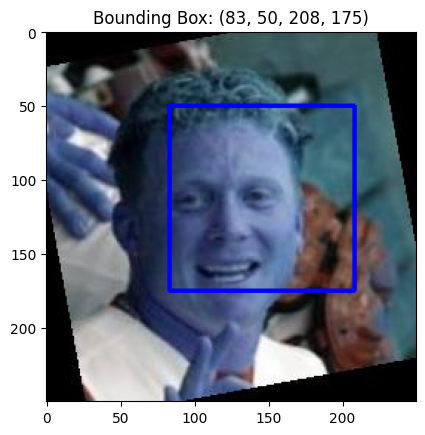

Immagine: AJ_Cook_0001.jpg
Coordinate del Bounding Box (x, y, x+w, y+h): (66, 100, 191, 225)


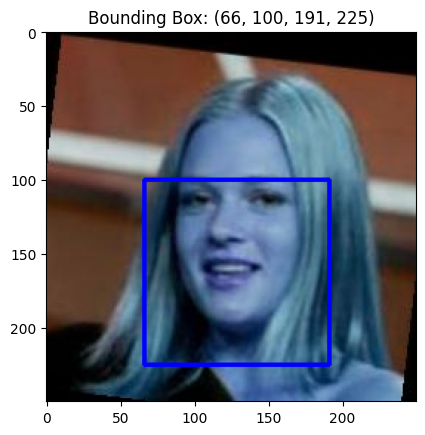

Immagine: AJ_Lamas_0001.jpg
Coordinate del Bounding Box (x, y, x+w, y+h): (33, 33, 158, 158)


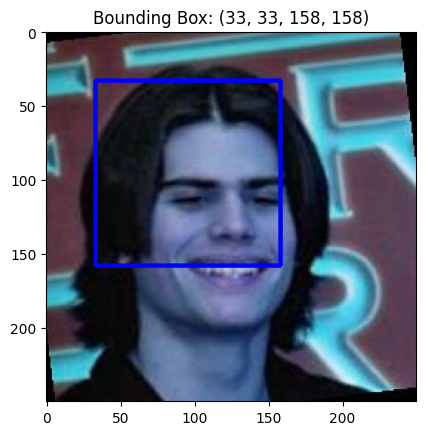

In [66]:
def plot_bounding_box(original_image, bounding_box, color=(255, 0, 0), thickness=2):
    # Extract coordinates and dimensions of bounding box
    x, y, w, h = bounding_box
    # Draw rectangle on original image
    image_with_box = cv2.rectangle(original_image.copy(), (x, y), (x + w, y + h), color, thickness)
    # Plot result
    plt.figure()
    plt.imshow(cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB))
    plt.title(f"Bounding Box: {(x, y, x + w, y + h)}")  # Mostra le coordinate come titolo
    plt.show()

# For every image
for image_name in images:
    # Verify if there's a bounding box
    if image_name in bounding_boxes:
        # Find the scale factor
        original_height, original_width = images[image_name].shape[:2]
        processed_height, processed_width = preprocessed_images[image_name].shape[:2]
        scale_x = original_width / processed_width
        scale_y = original_height / processed_height

        # Extract coordinates
        x, y, w, h = bounding_boxes[image_name]
        # Scale coordinates
        scaled_x = int(x * scale_x)
        scaled_y = int(y * scale_y)
        scaled_w = int(w * scale_x)
        scaled_h = int(h * scale_y)

        # Create scaled bounding box
        scaled_bounding_box = (scaled_x, scaled_y, scaled_w, scaled_h)

        # Print coordinates
        print(f"Immagine: {image_name}")
        print(f"Coordinate del Bounding Box (x, y, x+w, y+h): {(scaled_x, scaled_y, scaled_x + scaled_w, scaled_y + scaled_h)}")

        # Plot bounding box on original image
        plot_bounding_box(images[image_name], scaled_bounding_box)